In [197]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


TODO:
    
**Smoothing of the FT trace**

In [94]:
import pandas as pd
import pickle

In [79]:
columns = 'fx fy fz tx ty tz'.split()

In [124]:
NCHANNELS = 16

In [125]:
FADE_TIME = .5 # conf["FADE_TIME"] in the experimental script

In [32]:
CHANNEL_TO_G_MAPPING = [ (0,8), (1,9), (2,10), (3,11), (4,12), (5,13) ]
# Each pair (i,j) tells us that to get the corresponding G value, 
# you need to subtract the j-th channel from the i-th channel

In [29]:
sensmat = np.loadtxt('../../materials/sensor_transf_matrix_FT4714.csv',delimiter=',')

In [99]:
sensmat

array([[  1.65511985e-02,  -1.42809945e+00,  -3.45277170e-02,
          1.40042525e+00,   7.29228490e-03,  -7.59882860e-03],
       [  1.57292513e-02,  -8.61149120e-01,   7.00570980e-03,
         -7.64456725e-01,   1.78637230e-03,   1.88075540e+00],
       [  1.28474081e+00,   3.20435980e-03,   1.29878248e+00,
         -2.46638834e-02,   1.27234289e+00,   1.32178888e-02],
       [  7.63694206e+00,  -5.36376881e+00,  -7.03839477e+00,
         -4.37738150e+00,   3.33931731e-01,   1.14807216e+01],
       [  4.23847145e+00,   8.74154360e+00,   4.25050128e+00,
         -8.30650276e+00,  -8.22894604e+00,  -5.17339550e-01],
       [ -5.64898681e-02,   5.72458044e+00,  -2.41290809e-01,
          5.73492789e+00,   1.19903343e-02,   6.79064335e+00]])

In [100]:
PREFIX = 'neeraj/neeraj_1_arc_28_01.14h05m34'

In [50]:
def data_from_file(fname):
    dat = fromfile(fname)
    dat.shape
    nsamp = int(floor(dat.shape[0]/NCHANNELS))
    captured = dat[ :(nsamp*NCHANNELS) ].reshape(nsamp,NCHANNELS)
    Gs = array([ captured[:,i]-captured[:,j] for (i,j) in CHANNEL_TO_G_MAPPING ]).T  # nsamples x 6
    return Gs

In [108]:
import os

In [134]:
#N_TRIALS = 10
TRIALS = range(1,11)

In [135]:
#TRIALS

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [139]:
fs = ['%s__force_trial%d.bin'%(PREFIX,i) for i in TRIALS]

In [141]:
#fs

In [142]:
biasrec = '%s__bias_holding.bin'%PREFIX

In [143]:
biasG = data_from_file(biasrec)
biasG = mean(biasG,axis=0)

In [145]:
allft = {}
for trial,fname in zip(TRIALS,fs):
    
    Gs = data_from_file(fname)
    # Construct the matrix of Gs
    
    # Subtract bias
    G = Gs-biasG
    
    # Push through the sensor matrix to get the forces/torques
    Fs = sensmat.dot(G.T) ## TODO: is sensmat the 'right' way around?
    
    tab = pd.DataFrame(Fs.T)
    tab.columns=columns
    allft[trial]= tab

In [147]:
#allft

In [149]:
[ sum(isnan(tab['fx'])) for tab in allft.values() ]

[409, 0, 0, 0, 71, 0, 0, 0, 0, 579]

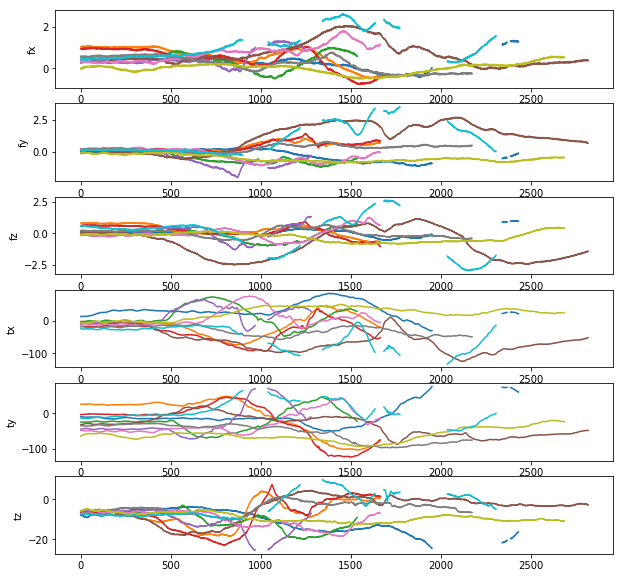

In [150]:
f,axs = subplots(6,1,figsize=(10,10))

for i,col in enumerate(columns):
    axs[i].set_ylabel(col)

for tab in allft.values():
    
    for i,col in enumerate(columns):
        
        axs[i].plot(tab[col],'-')

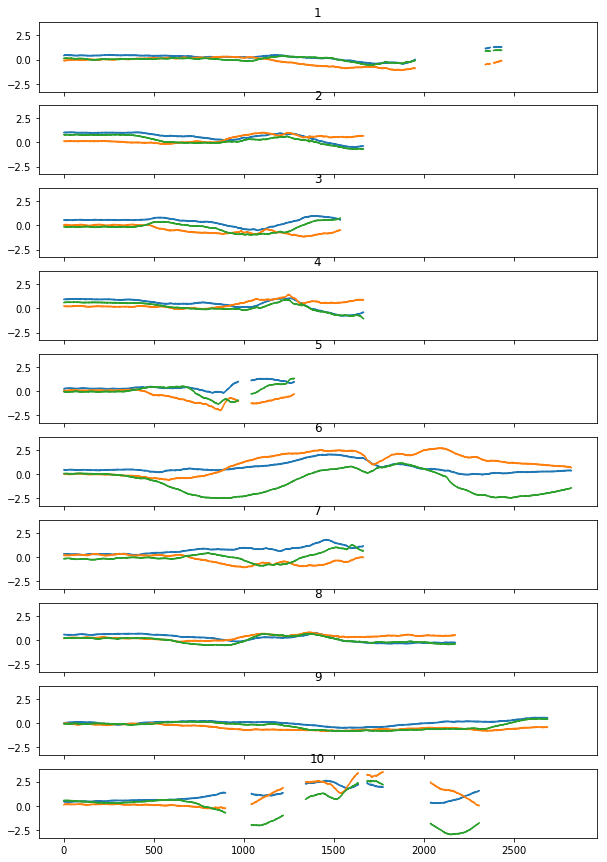

In [155]:
f,axs = subplots(len(TRIALS),1,figsize=(10,15),sharex=True,sharey=True)

for j,tr in enumerate(TRIALS):
    tab = allft[tr]
    
    for i,col in enumerate(columns[:3]):
        
        axs[j].plot(tab[col],'-')
    axs[j].set_title(tr)

Now let's read the captured trajectories and the trial data.

In [156]:
trialdat = pd.read_csv('%s_trials.txt'%PREFIX,sep=' ')
trialdat['t.stay']=trialdat['t.go']-FADE_TIME

In [130]:
#trialdat.iloc[0]

In [176]:
trajectories = pickle.load(open('%s_captured.pickle27'%PREFIX,'rb'))

In [177]:
trajectories[0]['trial']

1

In [178]:
def get_trial_data(tr):
    """ Get the data for a given trial, both the trial characteristics, trajectory and force trace """
    trj = [ t for t in trajectories if t['trial']==tr ][0]
    ft  = allft[tr]
    return trialdat[ trialdat['trial']==tr ].iloc[0],trj,ft

In [187]:
tmp = []
for tr in TRIALS:
    
    trialinfo,traj,ft = get_trial_data(tr)
    
    tmp.append({'trial':tr,
                't.stay':trialinfo['t.stay'],
                 't.comedi.start':trialinfo['t.comedi.start'],
                 't.comedi.stop':trialinfo['t.comedi.stop'],
                 
               'n.traj':len(traj['trajectory']),
               'n.ft':ft.shape[0]})
tmp = pd.DataFrame(tmp)

In [184]:
trialdat

,participant,experiment,trial,force.channel,target.x,target.y,t.go,t.movestart,t.target.enter,t.trial.end,timing,timing.numeric,duration,t.comedi.start,t.comedi.stop,t.stay
0,neeraj,arc,1,1,0.01,0.0,2.005914,3.213933,4.378533,4.479636,ok,0,1.265703,2.006049,4.511876,1.505914
1,neeraj,arc,2,1,-0.01,0.0,7.982824,8.680530,9.652361,9.753560,ok,0,1.073030,7.982951,9.777502,7.482824
2,neeraj,arc,3,1,0.01,0.0,13.256716,13.833301,14.733498,14.835309,ok,0,1.002008,13.256848,14.879429,12.756716
3,neeraj,arc,4,1,-0.01,0.0,18.338505,19.084284,19.941063,20.043152,ok,0,0.958868,18.338612,20.066888,17.838505
4,neeraj,arc,5,1,0.01,0.0,23.546401,24.047644,24.738078,24.839556,ok,0,0.791912,23.546547,24.858930,23.046401
5,neeraj,arc,6,1,-0.01,0.0,28.342720,28.791653,31.166631,31.268837,too_slow,-1,2.477184,28.342895,31.304898,27.842720
6,neeraj,arc,7,1,0.01,0.0,34.779360,35.578289,36.314767,36.414956,ok,0,0.836667,34.779453,36.548463,34.279360
7,neeraj,arc,8,1,-0.01,0.0,39.918223,40.688008,42.026661,42.127077,too_slow,-1,1.439069,39.918323,42.156010,39.418223
8,neeraj,arc,9,1,0.01,0.0,45.637280,46.301418,48.305309,48.406809,too_slow,-1,2.105391,45.637456,48.442148,45.137280
9,neeraj,arc,10,1,-0.01,0.0,51.919312,52.772400,54.244938,54.345829,too_slow,-1,1.573429,51.919406,54.377534,51.419312


In [191]:
tmp['t.diff']=tmp['t.comedi.start']-tmp['t.stay']
tmp['samp.diff']=tmp['n.traj']-tmp['n.ft']
tmp

,n.ft,n.traj,t.comedi.start,t.comedi.stop,t.stay,trial,t.diff,samp.diff
0,2434,3004,2.006049,4.511876,1.505914,1,0.500135,570
1,1665,2293,7.982951,9.777502,7.482824,2,0.500127,628
2,1537,2120,13.256848,14.879429,12.756716,3,0.500132,583
3,1666,2226,18.338612,20.066888,17.838505,4,0.500107,560
4,1281,1810,23.546547,24.858930,23.046401,5,0.500146,529
5,2821,3460,28.342895,31.304898,27.842720,6,0.500175,639
6,1665,2201,34.779453,36.548463,34.279360,7,0.500093,536
7,2176,2736,39.918323,42.156010,39.418223,8,0.500100,560
8,2689,3302,45.637456,48.442148,45.137280,9,0.500176,613
9,2309,2956,51.919406,54.377534,51.419312,10,0.500094,647


In [193]:
tmp = []
for tr in TRIALS:
    
    trialinfo,traj,ft = get_trial_data(tr)
    
    # Build "aligned" trajectory and force data
    n = ft.shape[0] # how many samples of force data we have
    xyz = zip(*traj['trajectory'][-n:])
    # ASSUMPTION HERE: the trajectory and FT sampling stopped at EXACTLY the same time
    # (which is almost certainly false but hey)
    
    for i,dm in enumerate(['x','y','z']):
        ft[dm]=xyz[i]
    ft
    

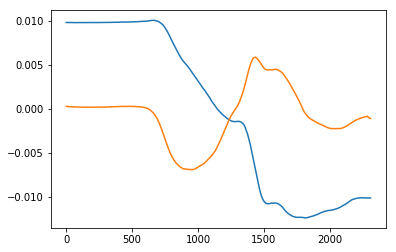

In [196]:
plot(ft['y'])
plot(ft['z'])


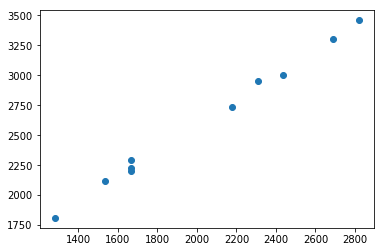

In [117]:
plot(tmp['n.ft'],tmp['n.traj'],'o')

In [59]:
G.shape

(2309, 6)

In [40]:
Gs.shape

(2309, 6)

In [15]:
captured.shape

(2309, 16)

In [ ]:
fname = 'test1_11_arc_18_01.17h36m19__bias_notholding.bin'

In [ ]:
plot(captured)